In [95]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [96]:
# global constant and flag
sd_imposed_threshold = 0.0035
sd_relaxed_threshold = 0.0005
sd_imposed = False

In [97]:
# seir_model_old: the seir_model without social distancing
def seir_model_nosd(t, y, beta, sigma, gamma):
    s, e, i, r = y
    return np.array([-beta * i * s,
                     -sigma * e + beta * i * s, 
                     -gamma * i + sigma * e, 
                     gamma * i])

In [98]:
# seir_model: the seir model to predict the population state over time:
# param array t: Time interval
# param y: the current population state
# param float beta: The parameter controlling how often a susceptible-infected contact results in a new infection.
# param float gamma: The rate an infected recovers and moves into the resistant phase.
# param float sigma: The rate at which an exposed person becomes infective.
# return: the next population state
def seir_model(t, y, beta, sigma, gamma):
    
    global sd_imposed
    
    #s: the percentage of individuals who are susceptible to the disease being modeled
    #e: the percentage of individuals who are exposed to the disease
    #i: the percentage of individuals infected with the disease
    #r; the percentage of individuals who can be removed from the system
    s, e, i, r = y

    # social distancing is imposed when it passes the threshould not relaxed when it passes another threshold
    effective_beta = beta
    if (not sd_imposed) and i >=  sd_imposed_threshold:
        sd_imposed = True
    if sd_imposed and i < sd_relaxed_threshold:
        sd_imposed = False
        
    # each period of social distancing reduces R0 by 60%
    # beta = R0 * gamma
    # shall we use R0??
    effective_beta = beta * 0.6 if sd_imposed else beta
    
    return np.array([-effective_beta * i * s,
                     -sigma * e + effective_beta * i * s, 
                     -gamma * i + sigma * e, 
                     gamma * i])

In [99]:
# solve: the solver for the IVP for the seir model given the initial setting
def solve_seir_model(t, y0, beta, sigma, gamma):
    return solve_ivp(lambda t, y: seir_model(t, y, beta, sigma, gamma), t, y0, rtol=1e-6)

In [100]:
# read USA data
df = pd.read_csv("time_series_us_cases_NYT.csv")

In [101]:
# choosing area to investigate: Washington
population_WA = 7656200.0
df_WA = df.loc[df['state'] == "Washington"].iloc[:,1:]

In [102]:
# initializing the SIER model
initial_population_state = [1 - (df_WA.iloc[0,0]/population_WA), df_WA.iloc[0,0]/population_WA, 0, 0]
time_interval = [0,len(df_WA.columns)]

In [103]:
# parameters tuning for SIER model
r0 = 0.85  # reproduction number after quarantine measures - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3539694
r0 = 2.4
r0 = 2.0
timePresymptomatic = 2.0  # almost half infections take place before symptom onset (Drosten) https://www.medrxiv.org/content/10.1101/2020.03.08.20032946v1.full.pdf  
# I in this model is maybe better described as 'Infectors'? Event infectious persons in quarantine do not count.
sigma = 1.0 / (5.2 - timePresymptomatic)  # The rate at which an exposed person becomes infectious.  symptom onset - presympomatic
# for SEIR: generationTime = 1/sigma + 0.5 * 1/gamma = timeFromInfectionToInfectiousness + timeInfectious  https://en.wikipedia.org/wiki/Serial_interval
generationTime = 4.6  # https://www.medrxiv.org/content/10.1101/2020.03.05.20031815v1  http://www.cidrap.umn.edu/news-perspective/2020/03/short-time-between-serial-covid-19-cases-may-hinder-containment
gamma = 1.0 / (2.0 * (generationTime - 1.0 / sigma))  # The rate an infectious is not recovers and moves into the resistant phase. Note that for the model it only means he does not infect anybody any more.
beta = r0 * gamma  # beta0 is used during days0 phase, beta1 after days0

In [104]:
# simulation for WA
# solve the IVP for the SIER model
sol = solve_seir_model(time_interval, initial_population_state, beta, sigma, gamma)

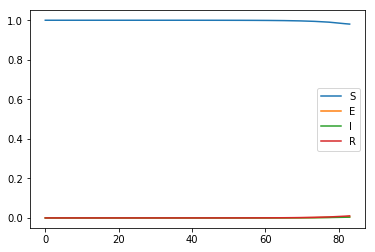

In [105]:
# simulation for WA
# plot S, E, I ,R
fig = plt.figure()
ax = fig.gca()
curves = ax.plot(sol.t, sol.y.T)
ax.legend(curves, ['S', 'E', 'I', 'R'])

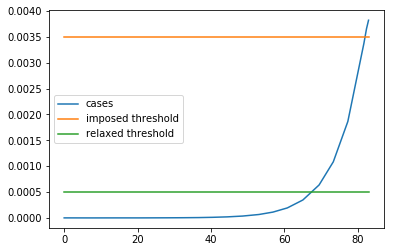

In [106]:
# simulation for WA
# plot I and thresholds
data = np.vstack((sol.y[2], np.full((sol.t.shape), sd_imposed_threshold), np.full((sol.t.shape), sd_relaxed_threshold))).T
fig = plt.figure()
ax = fig.gca()
curves = ax.plot(sol.t, data)
ax.legend(curves, ['cases', 'imposed threshold', 'relaxed threshold'])

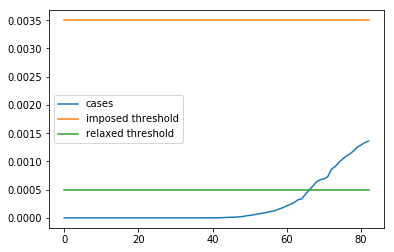

In [107]:
# real data for WA
# plot I and thresholds
data = np.vstack((df_WA.to_numpy() / population_WA, np.full((len(df_WA.columns)), sd_imposed_threshold), np.full((len(df_WA.columns)), sd_relaxed_threshold))).T
fig = plt.figure()
ax = fig.gca()
curves = ax.plot(np.array([i for i in range(0,len(df_WA.columns))]), data)
ax.legend(curves, ['cases', 'imposed threshold', 'relaxed threshold'])

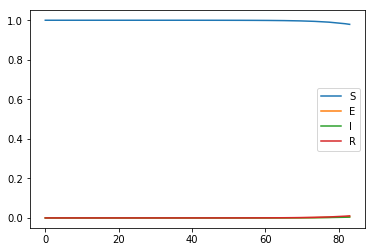

In [108]:
# simulation for WA
# simulation: the case without social distancing
sol_nosd = solve_ivp(lambda t, y: seir_model_nosd(t, y, beta, sigma, gamma), time_interval, initial_population_state, rtol=1e-6)
# plot S, E, I ,R
fig = plt.figure()
ax = fig.gca()
curves = ax.plot(sol_nosd.t, sol_nosd.y.T)
ax.legend(curves, ['S', 'E', 'I', 'R'])

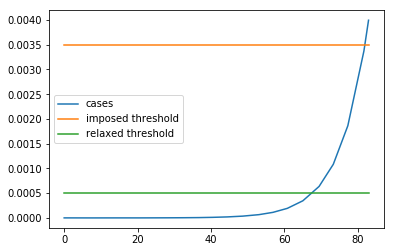

In [109]:
# simulation for WA
# plot I and thresholds
data = np.vstack((sol_nosd.y[2], np.full((sol_nosd.t.shape), sd_imposed_threshold), np.full((sol_nosd.t.shape), sd_relaxed_threshold))).T
fig = plt.figure()
ax = fig.gca()
curves = ax.plot(sol_nosd.t, data)
ax.legend(curves, ['cases', 'imposed threshold', 'relaxed threshold'])

In [36]:
'''
old code:

def seir_model(t, y, beta, sigma, gamma, sd_imposed):
    #s: the percentage of individuals who are susceptible to the disease being modeled
    #e: the percentage of individuals who are exposed to the disease
    #i: the percentage of individuals infected with the disease
    #r; the percentage of individuals who can be removed from the system
    s, e, i, r = y

    # social distancing is imposed when it passes the threshould not relaxed when it passes another threshold
    effective_beta = beta
    if (not sd_imposed) and i >=  sd_imposed_threshold:
        print("yes\n")
        sd_imposed = True
    if sd_imposed and i < sd_relaxed_threshold:
        sd_imposed = False
        
    # each period of social distancing reduces R0 by 60%
    # beta = R0 * gamma
    # shall we use R0??
    effective_beta = beta * 0.6 if sd_imposed else beta
    
    return np.array([-effective_beta * i * s,
                     -sigma * e + effective_beta * i * s, 
                     -gamma * i + sigma * e, 
                     gamma * i])
def solve_seir_model(t, y0, beta, sigma, gamma, sd_imposed):
    return solve_ivp(lambda t, y: seir_model(t, y, beta, sigma, gamma, sd_imposed), t, y0, rtol=1e-6)
'''

'\nold code:\n\ndef seir_model(t, y, beta, sigma, gamma, sd_imposed):\n    #s: the percentage of individuals who are susceptible to the disease being modeled\n    #e: the percentage of individuals who are exposed to the disease\n    #i: the percentage of individuals infected with the disease\n    #r; the percentage of individuals who can be removed from the system\n    s, e, i, r = y\n\n    # social distancing is imposed when it passes the threshould not relaxed when it passes another threshold\n    effective_beta = beta\n    if (not sd_imposed) and i >=  sd_imposed_threshold:\n        print("yes\n")\n        sd_imposed = True\n    if sd_imposed and i < sd_relaxed_threshold:\n        sd_imposed = False\n        \n    # each period of social distancing reduces R0 by 60%\n    # beta = R0 * gamma\n    # shall we use R0??\n    effective_beta = beta * 0.6 if sd_imposed else beta\n    \n    return np.array([-effective_beta * i * s,\n                     -sigma * e + effective_beta * i * s, \